## CNN for pixel-wise ship detection

CNN model from the article: [Ship Identification and Characterization in Sentinel-1 SAR Images with Multi-Task Deep Learning](https://doi.org/10.3390/rs11242997)

Dataset can be aqcuired [here:](https://gitlab.com/sarmaps/sar-ship-dataset), and the pre-processing description [here:](https://ieeexplore.ieee.org/document/7729017/algorithms?tabFilter=dataset#algorithms)


In [1]:
# change directory where requirments.txt is located
%cd  /content/drive/My Drive/projects/sar_ship_detect/scripts
!ls

/content/drive/My Drive/projects/sar_ship_detect/scripts
cfar.py       images	       __pycache__  requirements.txt   utils.py
cnn_utils.py  model_notebooks  README.md    under_development


In [2]:
# set up the required librariesS
!pip install -r requirements.txt

In [3]:
import os

import numpy as np 
import pandas as pd 
from collections import Counter
from os.path import join
from matplotlib import pyplot as plt
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
import pylab
import cv2
%matplotlib inline

# import sys
# sys.path.append(r'C:\Users\arman\Documents\GitHub\sar_ship_detect\scripts')
from utils import data_split, lee_filter, im_resize, bbox_draw, data_extractor, model_history_plot

In [5]:
PATH = '/content/drive/My Drive/projects/sar_ship_detect'
#data_path = join(os. getcwd(), '..','data', 'Iceberg-classifier-challenge')
data_path = join(PATH, 'data', 'very_deep_learn_data', 'json')

os.listdir(data_path)

['true_negatives.json', 'ship_positives.json', 'false_positives.json']

## Data Pre-processing


In [6]:
#Load the data.
ship_positives = pd.read_json(join(data_path, 'ship_positives.json'))
print('true_positives: ',ship_positives.shape)

true_positives:  (1, 1596)


In [7]:
# the following information is provided for each of the ship data
ship_positives[0][0].keys()

dict_keys(['id', 'sensor', 'resolution', 'fullname', 'polarisation', 'incidenceangle', 'row', 'column', 'longitude', 'latitude', 'stats', 'R', 'nearest', 'pixelsize', 'patchfu', 'patchgt', 'windowfu', 'windowgt', 'validais', 'ais', 'aux'])

In [8]:
np.array(ship_positives[0][0]['patchfu']).shape

(101, 101)

### Data extracton and resizing

We need to resize the images from chip size to **80x80** in order to matc with the CNN architecture puprosed in the artickle
(the chips are saved in either 21x21, 51x51 or 101x101 pixel spacing)

In [9]:
dsize = (80, 80)
dsize_40 = (40, 40)

# get true positive radar and angle daya
ship_positive_data = data_extractor(ship_positives, 'patchfu') # patchfu-101 |windowfu -21
# get the angle information
ship_positive_angle = data_extractor(ship_positives, 'incidenceangle', size=dsize)
# get the pixel based classes 
ship_positive_target = data_extractor(ship_positives, 'patchgt') # patchgt -101 |windowgt -21

# downscale the images into 40 pixel
ship_positive_40 = np.array([im_resize(image, dsize_40, interpolation=cv2.INTER_NEAREST) for image in ship_positive_data])
ship_positive_angle_40 = np.array([im_resize(image, dsize_40, interpolation=cv2.INTER_NEAREST) for image in ship_positive_angle])
ship_positive_target_40 = np.array([im_resize(image, dsize_40, interpolation=cv2.INTER_NEAREST) for image in ship_positive_target])

# upscale the images into 80
ship_positive_80 = np.array([im_resize(image, dsize, interpolation=cv2.INTER_NEAREST) for image in ship_positive_40])
ship_positive_angle_80 = np.array([im_resize(image, dsize, interpolation=cv2.INTER_NEAREST) for image in ship_positive_angle_40])
ship_positive_target_80 = np.array([im_resize(image, dsize, interpolation=cv2.INTER_NEAREST) for image in ship_positive_target_40])

data = np.concatenate([ship_positive_80[:, :, :, np.newaxis], ship_positive_angle_80[:, :, :, np.newaxis]], axis=-1)
target = np.array(ship_positive_target_80[:,:,:,np.newaxis])

In [10]:
print('Data shape:\t', data.shape)
print('Target shape:\t',target.shape)

Data shape:	 (1596, 80, 80, 2)
Target shape:	 (1596, 80, 80, 1)


### Data visualization

Text(0.5, 1.0, 'radar data')

<Figure size 432x288 with 0 Axes>

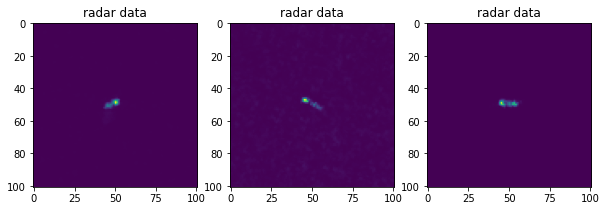

In [14]:
# visualize image samples 
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(10, 10)) 

# use the created array to output your multiple images. 
axarr[0].imshow(ship_positive_data[1200,:,:])
axarr[0].set_title('radar data')
axarr[1].imshow(ship_positive_data[14,:,:])  
axarr[1].set_title('radar data')
axarr[2].imshow(ship_positive_data[43,:,:])
axarr[2].set_title('radar data')

### Data split 

In [11]:
X_train_cv, X_valid, X_test, y_train_cv, y_valid, y_test = data_split(data, target, train_size=0.85, valid_size=0.25)

data split: 
Train: 	   1017 
Validation: 339 
Test: 	    240


In [16]:
target.flatten().shape

(10214400,)

In [17]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(target), target.flatten())

Buiding the Model

In [12]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D,UpSampling2D, Dense, Dropout, Input, Flatten, Activation, Reshape
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.metrics import binary_accuracy
from sklearn.metrics import classification_report, confusion_matrix
#import tensorflow_adons as tfa

Using TensorFlow backend.


In [13]:
# Deschesne ship detection model
def deschesne_model():
    model = Sequential()
    
    # conv block 1
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', input_shape=(80,80,2)))
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2))) # does this make 80x80 => 40x40 ?
    model.add(Dropout(0.1))
    
    # conv block 2
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2))) # image size: 80x80 => 40x40
    model.add(Dropout(0.1))
              
    # conv block 3
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    
    #Flatten the data for upcoming dense layers
    #model.add(Flatten())
    # fully connected block 1
    #model.add(Dense(64))
    
    # conv block 4
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    # reshape the tensor vector indo NxN for passing into Conv2D
    #model.add(Reshape((20,20), input_shape=(12,)))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Dropout(0.1))
              
    # conv block 4
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Dropout(0.1))
              
    # output Layer
    model.add(Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same'))  
    
    # compile model
    #mypotim = SGD(lr=0.01, momentum=0.9)
    #mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    mypotim = RMSprop(lr=0.001)
    model.compile(loss='binary_crossentropy', #'sparse_categorical_crossentropy',  
                  optimizer=mypotim,
                  metrics=['accuracy'])                     
    model.summary()
    return model


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

# save the best weights
#weights_path = ".model_weights_Deschesne_pixel_wise.hdf5"
weights_path = join(PATH, 'model_weights', '.Deschesne_pixel_wise_res_20m_80.hdf5')
callbacks = get_callbacks(filepath=weights_path, patience=4) # increased the "patience"

In [ ]:
#Without denoising, core features.
gmodel=deschesne_model()
history = gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks,
          class_weight=class_weights)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 80, 80, 128)       2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 40, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 256)       590080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 512)       1180160   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 512)      

In [15]:
# model validation evaluation
#gmodel.load_weights(weigth_path) # in case we save only the weights
gmodel = load_model(weights_path)

score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

339/339 [==============================] - 61s 181ms/step
Validation loss: 0.0015351776961528402
Validation accuracy: 0.9994874596595764


In [16]:
# model test evaluation
score = gmodel.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

240/240 [==============================] - 43s 180ms/step
Test loss: 0.0016232724146296581
Test accuracy: 0.9994531273841858


In [17]:
# get predicted target values 
y_pred = gmodel.predict(X_test, batch_size=64, verbose=1)
y_pred_class = gmodel.predict_classes(X_test, batch_size=64, verbose=1)

240/240 [==============================] - 43s 180ms/step


In [18]:
# Classification report for Image size: 21x21 
labels = ['0-not ship', '1-ship']

print()
print('Image size: 80x80 \n', classification_report(y_test.flatten(), y_pred_class.flatten()))
print('Confusion matrix \n', confusion_matrix(y_test.flatten(), y_pred_class.flatten()))


Image size: 80x80 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1534204
           1       0.86      0.63      0.73      1796

    accuracy                           1.00   1536000
   macro avg       0.93      0.82      0.87   1536000
weighted avg       1.00      1.00      1.00   1536000

Confusion matrix 
 [[1534022     182]
 [    658    1138]]


### Visualize the classification outputs 
Let's plot some images to compare the `actual data vs predicted data`, and `actual labels vs predicted labels`. One should keep in mind that the images undergone to size transformation.

#### Draw bound boxes 
The bboxes are created based on binary classification and it will fail if we try to apply on another type of images.

In [19]:
# reduce the dimensionality 
X_test_value = X_test[:,:,:,0]
y_test_label = y_test.squeeze()
y_pred_value = y_pred.squeeze()
# get the binary prediction
y_pred_label = y_pred_class.squeeze()

<Figure size 432x288 with 0 Axes>

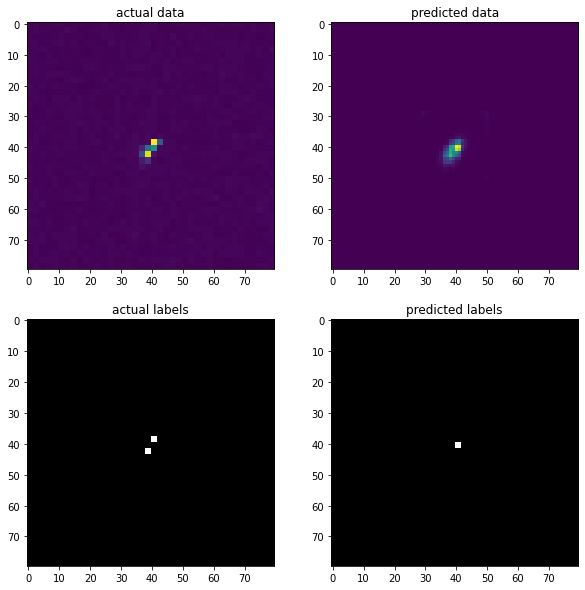

In [20]:
# define functions for vizualization 
def multiple_im_plot(no_image):
    
    plt.figure()

    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(2,2, figsize=(10, 10)) 

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr[0,0].imshow(X_test_value[no_image])
    axarr[0,0].set_title('actual data')
    axarr[0,1].imshow(y_pred_value[no_image])  
    axarr[0,1].set_title('predicted data')
    axarr[1,0].imshow(y_test_label[no_image], cmap="gray")
    axarr[1,0].set_title('actual labels')
    axarr[1,1].imshow(y_pred_label[no_image], cmap="gray") 
    axarr[1,1].set_title('predicted labels')
    
# visualize prediction examples 
multiple_im_plot(67)